In [1]:
import random
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as nnf

from util import load_Cifar10

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, base_channels, num_layers):
        """
        Args:
            input_channels (int): number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
            base_channels (int): number of filters in the first conv layer.
            num_layers (int): total number of conv layers.
        """
        super(ConvEncoder, self).__init__()
        layers = []
        in_channels = input_channels
        # We use a constant kernel size, stride, and padding.
        kernel_size = 3
        stride = 2  # downsampling by a factor of 2 each time
        padding = 1
        
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)

class ConvDecoder(nn.Module):
    def __init__(self, output_channels, base_channels, num_layers):
        """
        Args:
            output_channels (int): number of channels in the output image.
            base_channels (int): should match the encoder's base_channels.
            num_layers (int): total number of conv transpose layers.
        """
        super(ConvDecoder, self).__init__()
        layers = []
        # Start with the number of channels at the bottleneck (last encoder layer)
        in_channels = base_channels * (2 ** (num_layers - 1))
        kernel_size = 3
        stride = 2  # upsampling by a factor of 2 each time
        padding = 1
        output_padding = 1  # usually needed to exactly invert the spatial dimension reduction

        # Reverse the process of the encoder.
        for i in range(num_layers +1, 0, -1):
            out_channels = base_channels * (2 ** (i - 1))
            layers.append(nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size=kernel_size, stride=stride,
                                             padding=padding, output_padding=output_padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        # Final layer to get back to the desired output channels.
        layers.append(nn.ConvTranspose2d(in_channels, output_channels,
                                         kernel_size=kernel_size, stride=stride,
                                         padding=padding, output_padding=output_padding))
        
        self.decoder = nn.Sequential(*layers)
        

    def forward(self, x):
        return self.decoder(x)

class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels, num_layers):
        super(ConvAutoencoder, self).__init__()
        self.encoder = ConvEncoder(input_channels, base_channels, num_layers)
        self.decoder = ConvDecoder(output_channels, base_channels, num_layers)  
        self.combiner = nn.Conv2d(output_channels*2, output_channels, kernel_size=1, stride=1, padding=0)
        self.loss = []
    def forward(self, x_lr, x_lr_up):
        latent = self.encoder(x_lr)
        output = self.decoder(latent)
        reconstruction = nnf.sigmoid(self.combiner(torch.cat((output, x_lr_up), 1)))
        return reconstruction

In [16]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 512

lr = 1e-4
epochs = 1000
batch_size = 1024

train_dataset, test_dataset, train_loader, test_loader, classes = load_Cifar10(batch_size)
num_train_data = len(train_dataset)

In [4]:
model = ConvAutoencoder(input_channels=3, output_channels=3, base_channels=32, num_layers=2).to(DEVICE)

# from torchsummary import summary
# summary(model, (3, 8, 8))

from torchvision import models

In [17]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]  # Use first layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return nnf.mse_loss(pred_features, target_features)  # Feature-level loss
    
perceptual_loss = PerceptualLoss().to(DEVICE)
# train the model
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(8, 8), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)
        x_inp_high = nnf.interpolate(x_inp, size=(32, 32), mode='bicubic', align_corners=False)
        x_inp_high = x_inp_high.to(DEVICE)
        x = x.to(DEVICE)
        optimizer.zero_grad()

        x_hat = model.forward(x_inp, x_inp_high)

        #loss = criterion(x_hat_combined, x)
        loss = perceptual_loss(x_hat, x)
        overall_loss += loss.item() / num_train_data
        # backpropagation
        loss.backward()
        optimizer.step()
    # print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.loss.append(overall_loss)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [10/1000], Loss: 3.6780
Epoch [20/1000], Loss: 3.7501
Epoch [30/1000], Loss: 3.7002
Epoch [40/1000], Loss: 3.6709
Epoch [50/1000], Loss: 3.6135
Epoch [60/1000], Loss: 3.6677
Epoch [70/1000], Loss: 3.7253
Epoch [80/1000], Loss: 3.7187
Epoch [90/1000], Loss: 3.6604
Epoch [100/1000], Loss: 3.6917
Epoch [110/1000], Loss: 3.6346
Epoch [120/1000], Loss: 3.6949


KeyboardInterrupt: 

[]

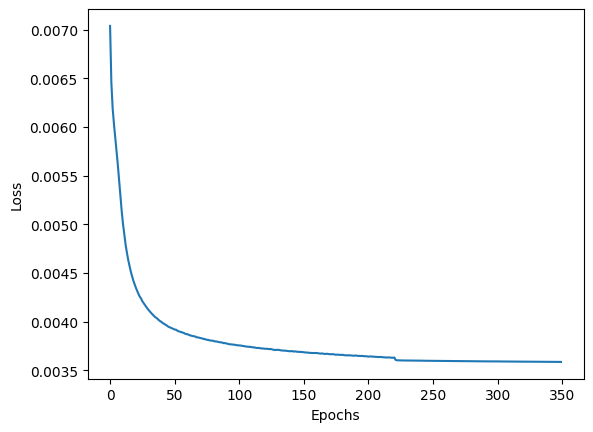

In [18]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [19]:
from tqdm import tqdm
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(8, 8), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)
        x_inp_high = nnf.interpolate(x_inp, size=(32, 32), mode='bicubic', align_corners=False)
        x_inp_high = x_inp_high.to(DEVICE)
        x = x.to(DEVICE)

        x_hat = model(x_inp, x_inp_high)
        break

  0%|          | 0/10 [00:07<?, ?it/s]


In [20]:
def show_image(x, x_inp, x_hat, n):


    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

        axs[3,i].imshow(x_inp_high[i].permute(1, 2, 0).cpu().numpy())
        axs[3, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0056998087..0.95476586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013254444..0.95699304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08439326..1.0167874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10920823..1.033944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04707031..1.0005553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0363125..1.063431].


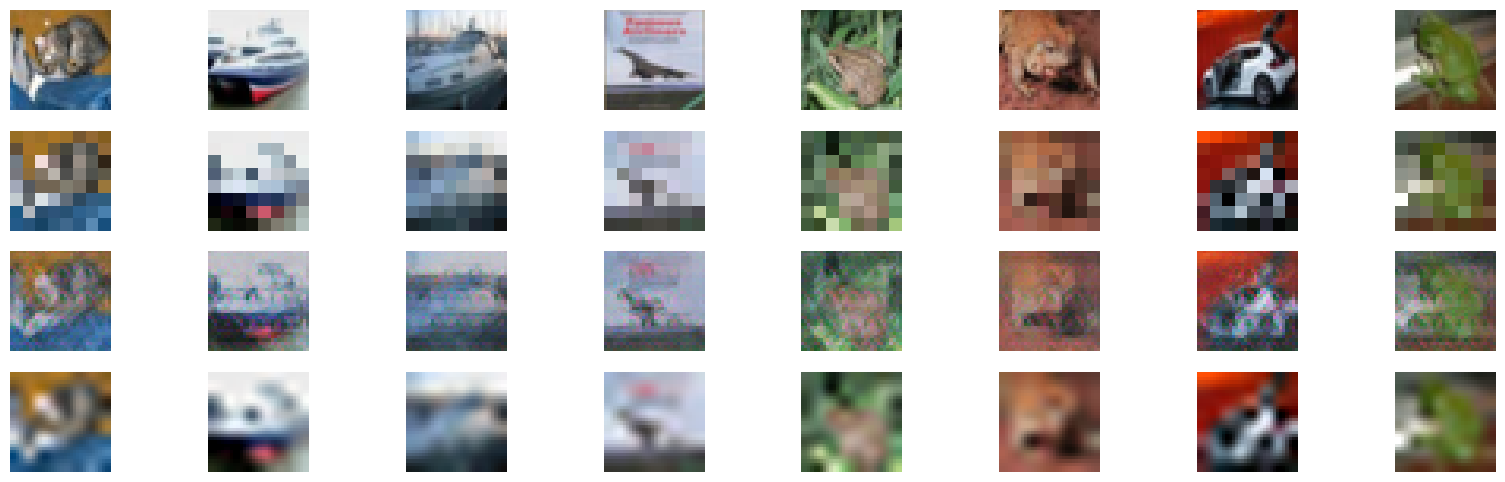

In [21]:
show_image(x, x_inp, x_hat, 8)

In [22]:
torch.save(model.state_dict(), "CIFAR_perceptual_all_conv.pth")